Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Denoising Diffusion Probabilistic Models with MedNIST Dataset

This tutorial illustrates how to use MONAI for training a denoising diffusion probabilistic model (DDPM)[1] to create
synthetic 2D images.

[1] - Ho et al. "Denoising Diffusion Probabilistic Models" https://arxiv.org/abs/2006.11239


## Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import ignite" || pip install -q pytorch-ignite
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
from ignite.contrib.handlers import ProgressBar
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.engines import SupervisedEvaluator, SupervisedTrainer
from monai.handlers import MeanAbsoluteError, MeanSquaredError, StatsHandler, ValidationHandler, from_engine
from monai.utils import first, set_determinism
from monai.inferers import DiffusionInferer
from monai.engines import DiffusionPrepareBatch
from monai.networks.nets import DiffusionModelUNet
from monai.networks.schedulers import DDPMScheduler

print_config()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


MONAI version: 1.4.0rc6
Numpy version: 1.26.4
Pytorch version: 2.3.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 6a0e1b043ba2890e1463fa49df76f66e56a68b08
MONAI __file__: /home/<username>/miniconda3/envs/monai/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.2.1
scikit-image version: 0.23.2
scipy version: 1.13.1
Pillow version: 10.3.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.18.1+cu121
tqdm version: 4.66.4
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.14.0
pynrrd version: 1.0.0
clearml version: 1.16.2rc0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the MONAI_DATA_DIRECTORY environment variable.

This allows you to save results and reuse downloads.

If not specified a temporary directory will be used.

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpss9epssa


## Set deterministic training for reproducibility

In [3]:
set_determinism(0)

## Setup MedNIST Dataset and training and validation dataloaders
In this tutorial, we will train our models on the MedNIST dataset available on MONAI
(https://docs.monai.io/en/stable/apps.html#monai.apps.MedNISTDataset). In order to train faster, we will select just
one of the available classes ("Hand"), resulting in a training set with 7999 2D images.

In [4]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, progress=False, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]
batch_size = 64
num_workers = 4

2024-09-02 17:51:05,299 - INFO - Downloaded: /tmp/tmpss9epssa/MedNIST.tar.gz
2024-09-02 17:51:05,410 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-09-02 17:51:05,411 - INFO - Writing into directory: /tmp/tmpss9epssa.


Here we use transforms to augment the training dataset:

1. `LoadImaged` loads the hands images from files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `ScaleIntensityRanged` extracts intensity range [0, 255] and scales to [0, 1].
1. `RandAffined` efficiently performs rotate, scale, shear, translate, etc. together based on PyTorch affine transform.

In [5]:
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[64, 64],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)
train_ds = CacheDataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, persistent_workers=True
)

Loading dataset: 100%|██████████| 7999/7999 [00:05<00:00, 1366.06it/s]


In [6]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, progress=False, seed=0)
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "Hand"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True)

2024-09-02 17:51:36,290 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-09-02 17:51:36,291 - INFO - File exists: /tmp/tmpss9epssa/MedNIST.tar.gz, skipped downloading.
2024-09-02 17:51:36,292 - INFO - Non-empty folder exists in /tmp/tmpss9epssa/MedNIST, skipped extracting.


Loading dataset: 100%|██████████| 1005/1005 [00:00<00:00, 1476.42it/s]


### Visualisation of the training images

batch shape: torch.Size([64, 1, 64, 64])


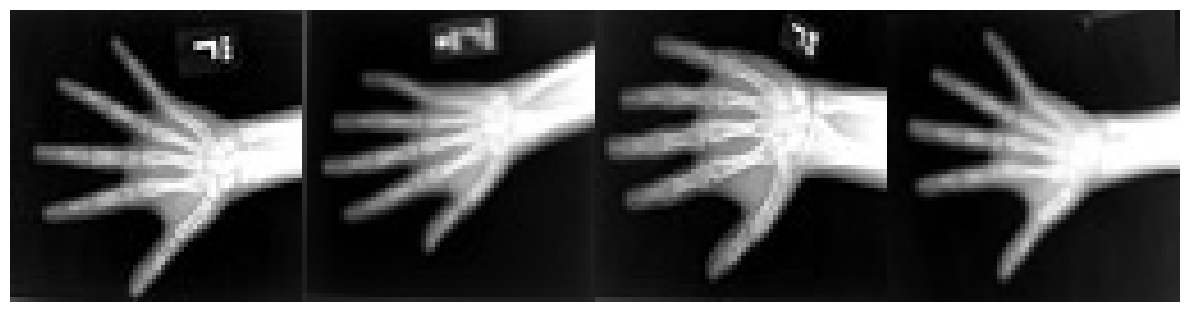

In [7]:
check_data = first(train_loader)
print(f"batch shape: {check_data['image'].shape}")
image_visualisation = torch.cat(
    [check_data["image"][0, 0], check_data["image"][1, 0], check_data["image"][2, 0], check_data["image"][3, 0]], dim=1
)
plt.figure("training images", (12, 6))
plt.imshow(image_visualisation, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

### Define network, scheduler, optimizer, and inferer
At this step, we instantiate the MONAI components to create a DDPM, the UNET, the noise scheduler, and the inferer used for training and sampling. We are using
the original DDPM scheduler containing 1000 timesteps in its Markov chain, and a 2D UNET with attention mechanisms
in the 2nd and 3rd levels, each with 1 attention head.

In [8]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(64, 128, 128),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=(0, 128, 128),
)
model.to(device)

num_train_timesteps = 1000
scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

### Model training
Here, we are training our model for 75 epochs (training time: ~50 minutes).

In [9]:
max_epochs = 75
val_interval = 5

val_handlers = [StatsHandler(name="train_log", output_transform=lambda x: None)]

evaluator = SupervisedEvaluator(
    device=device,
    val_data_loader=val_loader,
    network=model,
    inferer=inferer,
    prepare_batch=DiffusionPrepareBatch(num_train_timesteps=num_train_timesteps),
    key_val_metric={"val_mean_abs_error": MeanAbsoluteError(output_transform=from_engine(["pred", "label"]))},
    val_handlers=val_handlers,
)


train_handlers = [
    ValidationHandler(validator=evaluator, interval=val_interval, epoch_level=True),
    # StatsHandler(name="train_log", tag_name="train_loss", output_transform=from_engine(["loss"], first=True)),
]

trainer = SupervisedTrainer(
    device=device,
    max_epochs=max_epochs,
    train_data_loader=train_loader,
    network=model,
    optimizer=optimizer,
    loss_function=torch.nn.MSELoss(),
    inferer=inferer,
    prepare_batch=DiffusionPrepareBatch(num_train_timesteps=num_train_timesteps),
    key_train_metric={"train_acc": MeanSquaredError(output_transform=from_engine(["pred", "label"]))},
    train_handlers=train_handlers,
)

out_func = from_engine("loss")


def _output_transform(data):
    losses = out_func(data)
    return losses[0]


ProgressBar(
    persist=True, bar_format="[{n_fmt}/{total_fmt}] {percentage:3.0f}%{postfix} [{elapsed}<{remaining}]"
).attach(trainer, output_transform=_output_transform)


trainer.run()

[125/125] 100% , output=0.438 [00:25<00:00]
[125/125] 100% , output=0.15 [00:24<00:00] 
[125/125] 100% , output=0.0478 [00:24<00:00]
[125/125] 100% , output=0.0241 [00:24<00:00]
[125/125] 100% , output=0.0232 [00:24<00:00]
...


[125/125] 100% , output=0.00982 [00:26<00:00]
[125/125] 100% , output=0.00456 [00:24<00:00]
[125/125] 100% , output=0.0198 [00:24<00:00] 
[125/125] 100% , output=0.0176 [00:24<00:00] 
[125/125] 100% , output=0.00711 [00:24<00:00]
[125/125] 100% , output=0.0108 [00:24<00:00] 

2024-09-02 18:23:20,504 - INFO - Epoch[75] Metrics -- val_mean_abs_error: 0.0470 
2024-09-02 18:23:20,505 - INFO - Key metric: val_mean_abs_error best value: 0.078772634267807 at epoch: 5


[125/125] 100% , output=0.0108 [00:25<00:00]


### Plotting sampling process along DDPM's Markov chain

100%|██████████| 1000/1000 [00:09<00:00, 104.03it/s]


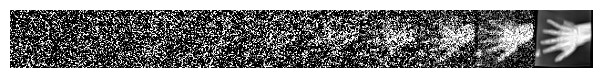

In [10]:
model.eval()
noise = torch.randn((1, 1, 64, 64))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
image, intermediates = inferer.sample(
    input_noise=noise, diffusion_model=model, scheduler=scheduler, save_intermediates=True, intermediate_steps=100
)

chain = torch.cat(intermediates, dim=-1)

plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

### Cleanup data directory

Remove directory if a temporary was used.

In [11]:
if directory is None:
    shutil.rmtree(root_dir)